### 令和6年6月25日(火)

#### スコアが0.76いかなくなった。以前のスコアまで戻す
objectiveはbinary,regressionどちらが良い？→binary <br>
lgbmを使う場合nanを-9999などで埋めるべきかそのままにするべきか→そのまま<br>
日数を年に直す意味はあるのか？（-365） 少し意味あるかも<br>
新規　occupation_type:low_skill_laborsかそうで無いかでラベル付け

#### 1. 読み込み

In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# LGBMClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from hyperopt import hp, fmin, tpe, Trials
import warnings
warnings.filterwarnings('ignore')

In [2]:
# exel表にparameter,scoreを記録する関数
import os
def save_score_to_exel(exel_path , best: dict, score, time):
    columns = list(best.keys())
    columns.append('score')
    columns.append('time')
    old = pd.DataFrame(columns = columns)
    if not os.path.exists(exel_path):
        old.to_excel(exel_path)
    old = pd.read_excel(exel_path, index_col=0)
    data = list(best.values())
    data.append(score)
    data.append(time)
    new = np.array([data])
    score_data = pd.DataFrame(columns = columns, data = new)
    new = pd.concat([old, score_data])
    new.to_excel(exel_path)

In [3]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = "../input/"
import datetime
time = datetime.datetime.now().strftime('%Y%m%d%H%M')
output_path = "C:/Users/gwsgs/workSpace/GCIcomp2/02.（公開）コンペ2/output/"
train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")
X_train = train.drop('TARGET',axis=1)
y_train = train['TARGET']

#### 2. 前処理と特徴量作成
ここでは、上記の可視化と分析でわかったことを踏まえて、前処理と特徴量の作成を行います。

In [4]:
# 欠損値の補完を行う
# FLAF_OWN_CARの欠損値をラベルエンコーディングで補完
train["FLAG_OWN_CAR"].fillna('Unknown', inplace=True)
train["FLAG_OWN_CAR"] = train["FLAG_OWN_CAR"].map(train['FLAG_OWN_CAR'].value_counts().rank(ascending=False, method='first'))
test["FLAG_OWN_CAR"].fillna('Unknown', inplace=True)
test["FLAG_OWN_CAR"] = test["FLAG_OWN_CAR"].map(test['FLAG_OWN_CAR'].value_counts().rank(ascending=False, method='first'))

# train["FLAG_OWN_CAR"].fillna(2, inplace=True)
# train["FLAG_OWN_CAR"] = train["FLAG_OWN_CAR"].map({"Y": 1, "N": 0, 2: 2})
# test["FLAG_OWN_CAR"].fillna(2, inplace=True)
# test["FLAG_OWN_CAR"] = test["FLAG_OWN_CAR"].map({"Y": 1, "N": 0, 2: 2})
# FLAG_OWN_REALTYの欠損値はをラベルカウントエンコーディングで補完
train["FLAG_OWN_REALTY"].fillna('Unknown', inplace=True)
train["FLAG_OWN_REALTY"] = train["FLAG_OWN_REALTY"].map(train["FLAG_OWN_REALTY"].value_counts().rank(ascending=False, method='first'))
test["FLAG_OWN_REALTY"].fillna('Unknown', inplace=True)
test["FLAG_OWN_REALTY"] = test["FLAG_OWN_REALTY"].map(test["FLAG_OWN_REALTY"].value_counts().rank(ascending=False, method='first'))

# train["FLAG_OWN_REALTY"].fillna(2, inplace=True)
# train["FLAG_OWN_REALTY"] = train["FLAG_OWN_REALTY"].map({"Y": 1, "N": 0, 2: 2})
# test["FLAG_OWN_REALTY"].fillna(2, inplace=True)
# test["FLAG_OWN_REALTY"] = test["FLAG_OWN_REALTY"].map({"Y": 1, "N": 0, 2: 2})
# AMT_ANNUITYの欠損値を中央値で補完
train["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].median(), inplace=True)
test["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].median(), inplace=True)
# AMT_GOODS_PRICEの欠損値を中央値で補完
train["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].median(), inplace=True)
test["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].median(), inplace=True)
# NAME_TYPE_SUITEの欠損値をラベルカウントエンコーディングで補完
train["NAME_TYPE_SUITE"].fillna("Unknown", inplace=True)
train["NAME_TYPE_SUITE"] = train["NAME_TYPE_SUITE"].map(train["NAME_TYPE_SUITE"].value_counts().rank(ascending=False, method='first'))
test["NAME_TYPE_SUITE"].fillna("Unknown", inplace=True)
test["NAME_TYPE_SUITE"] = test["NAME_TYPE_SUITE"].map(test["NAME_TYPE_SUITE"].value_counts().rank(ascending=False, method='first'))
# OWN_CAR_AGEの欠損値を-9999で補完　欠損値は欠損値のまま扱う方が結果が良い？
# train["OWN_CAR_AGE"].fillna(-9999, inplace=True)
# test["OWN_CAR_AGE"].fillna(-9999, inplace=True)
# OCCUPATION_TYPEの欠損値をラベルエンコーディングで補完
train["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)
train["OCCUPATION_TYPE"] = train["OCCUPATION_TYPE"].map(train["OCCUPATION_TYPE"].value_counts().rank(ascending=False, method='first'))
test["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)
test["OCCUPATION_TYPE"] = test["OCCUPATION_TYPE"].map(test["OCCUPATION_TYPE"].value_counts().rank(ascending=False, method='first'))
# CNT_FAM_MEMBERSの欠損値を中央値で補完
train["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)
test["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)
# # # EXT_SOURCE_1の欠損値を-9999で補完
# train['EXT_SOURCE_1'] = train['EXT_SOURCE_1'].fillna(-9999)
# test['EXT_SOURCE_1'] = test['EXT_SOURCE_1'].fillna(-9999)
# # EXT_SOURCE_2の欠損値を平均値で補完
# train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
# test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
# # EXT_SOURCE_3の欠損値を-9999で補完
# train['EXT_SOURCE_3'] = train['EXT_SOURCE_2'].fillna(-9999)
# test['EXT_SOURCE_3'] = test['EXT_SOURCE_2'].fillna(-9999)


In [5]:
# カテゴリカルデータを数値に変換
# NAME_CONTRACT_TYPEのラベルエンコーディング
train["NAME_CONTRACT_TYPE"] = train["NAME_CONTRACT_TYPE"].map({"Cash loans": 0, "Revolving loans": 1})
test["NAME_CONTRACT_TYPE"] = test["NAME_CONTRACT_TYPE"].map({"Cash loans": 0, "Revolving loans": 1})
# CODE_GENDERのラベルエンコーディング(男性=0, 女性=1, XNA=0)
train["CODE_GENDER"] = train["CODE_GENDER"].map({"M": 0, "F": 1, "XNA": 0})
test["CODE_GENDER"] = test["CODE_GENDER"].map({"M": 0, "F": 1, "XNA": 0})
# NAME_INCOME_TYPEのラベルカウントエンコーディング
train["NAME_INCOME_TYPE"] = train["NAME_INCOME_TYPE"].map(train["NAME_INCOME_TYPE"].value_counts().rank(ascending=False, method='first'))
test["NAME_INCOME_TYPE"] = test["NAME_INCOME_TYPE"].map(test["NAME_INCOME_TYPE"].value_counts().rank(ascending=False, method='first'))
# NAME_EDUCATION_TYPEのラベルカウントエンコーディング
train["NAME_EDUCATION_TYPE"] = train["NAME_EDUCATION_TYPE"].map(train["NAME_EDUCATION_TYPE"].value_counts().rank(ascending=False, method='first'))
test["NAME_EDUCATION_TYPE"] = test["NAME_EDUCATION_TYPE"].map(test["NAME_EDUCATION_TYPE"].value_counts().rank(ascending=False, method='first'))
# NAME_FAMILY_STATUSのラベルカウントエンコーディング
train["NAME_FAMILY_STATUS"] = train["NAME_FAMILY_STATUS"].map(train["NAME_FAMILY_STATUS"].value_counts().rank(ascending=False, method='first'))
test["NAME_FAMILY_STATUS"] = test["NAME_FAMILY_STATUS"].map(test["NAME_FAMILY_STATUS"].value_counts().rank(ascending=False, method='first'))
# NAME_HOUSING_TYPEのラベルカウントエンコーディング
train["NAME_HOUSING_TYPE"] = train["NAME_HOUSING_TYPE"].map(train["NAME_HOUSING_TYPE"].value_counts().rank(ascending=False, method='first'))
test["NAME_HOUSING_TYPE"] = test["NAME_HOUSING_TYPE"].map(test["NAME_HOUSING_TYPE"].value_counts().rank(ascending=False, method='first'))
# ORGANIZATIONのラベルカウントエンコーディング
train["ORGANIZATION_TYPE"] = train["ORGANIZATION_TYPE"].map(train["ORGANIZATION_TYPE"].value_counts().rank(ascending=False, method='first'))
test["ORGANIZATION_TYPE"] = test["ORGANIZATION_TYPE"].map(test["ORGANIZATION_TYPE"].value_counts().rank(ascending=False, method='first'))

In [6]:
# 特徴量の作成
# DAYS_LAST_PHONE_CHANGEを年に変換
train["YEARS_PHONR_CHANGE"] = train["DAYS_LAST_PHONE_CHANGE"] / -365
test["YEARS_PHONR_CHANGE"] = test["DAYS_LAST_PHONE_CHANGE"] / -365
# DAYS_EMPLOYEDを年に変換
train["YEARS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 365
test["YEARS_EMPLOYED"] = test["DAYS_EMPLOYED"] / 365
# DAYS_REGISTRATIONを年に変換
train["YEARS_REGISTRATION"] = train["DAYS_REGISTRATION"] / -365
test["YEARS_REGISTRATION"] = test["DAYS_REGISTRATION"] / -365
# DAYS_ID_PUBLISHを年に変換
train["YEARS_ID_PUBLISH"] = train["DAYS_ID_PUBLISH"] / -365
test["YEARS_ID_PUBLISH"] = test["DAYS_ID_PUBLISH"] / -365
# OCCUPATION_TYPEのLow-skill Laborersを1、それ以外を0に変換。新しく特徴量[is_low_skill]を作成
train["is_low_skill"] = train["OCCUPATION_TYPE"].apply(lambda x: 1 if x == "Low-skill Laborers" else 0)
test["is_low_skill"] = test["OCCUPATION_TYPE"].apply(lambda x: 1 if x == "Low-skill Laborers" else 0)
# 参考 https://www.kaggle.com/competitions/home-credit-default-risk/discussion/64821
# AMT_CREDITとAMT_ANNUITYの比率
train["CREDIT_TO_ANNUITY_RATIO"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["CREDIT_TO_ANNUITY_RATIO"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# AMT_CREDITとAMT_GOODS_PRICEの比率
train["CREDIT_TO_GOODS_RATIO"] = train["AMT_CREDIT"] / train["AMT_GOODS_PRICE"]
test["CREDIT_TO_GOODS_RATIO"] = test["AMT_CREDIT"] / test["AMT_GOODS_PRICE"]
# AMT_CREDITとAMT_ANNUITYの比率
train["AMT_CREDIT_TO_AMT_ANNUITY"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["AMT_CREDIT_TO_AMT_ANNUITY"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# DAYS_BIRTH/ -365
train["YEARS_BIRTH"] = train["DAYS_BIRTH"] / -365
test["YEARS_BIRTH"] = test["DAYS_BIRTH"] / -365

In [7]:
# 目的変数と説明変数に分割
X = train.drop("TARGET", axis=1).values
y = train["TARGET"].values
X_test = test.values
# 訓練データと評価データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

## 3. 予測

In [8]:
params = {
    'random_state': 0,
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': hp.randint('num_leaves',2, 100),
    'max_depth': hp.randint('max_depth',2, 3),
    'n_estimators': hp.randint('n_estimators',800, 1200),
    'learning_rate': hp.uniform('learning_rate', 0.005 ,0.2),
    # 'min_child_samples': hp.randint('min_child_samples',5, 10),
    'reg_lamb': hp.uniform('reg_lamb', 0, 40),
    'bagging_freq': hp.randint('bagging_freq', 1, 10),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 1),
    'min_data_in_leaf': hp.randint('min_data_in_leaf', 10, 100),
}

In [9]:
def objective(args):
    lgb = LGBMClassifier(
        num_leaves = args['num_leaves'],
        max_depth = args['max_depth'],
        n_estimators = args['n_estimators'],
        learning_rate = args['learning_rate'],
        # min_child_samples = args['min_child_samples'],
        reg_lambda = args['reg_lamb'],
        bagging_freq = args['bagging_freq'],
        bagging_fraction = args['bagging_fraction'],
        feature_fraction = args['feature_fraction'],
        min_data_in_leaf = args['min_data_in_leaf'],
        random_state = params['random_state'],
        objective = params['objective'],
        metric = params['metric'],
        verbosity = params['verbosity'],
        boosting_type = params['boosting_type'],
        early_stopping_round = 50
        )
    lgb.fit(X_train, y_train,
            eval_set = [(X_valid, y_valid)]
        )
    lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, lgb_valid_pred)
    return -1.0 * auc   

In [10]:
n_iter = 2000
trials = Trials()
best = fmin(
    objective,
    space = params,
    algo=tpe.suggest,
    max_evals=n_iter,
    trials=trials,
    # 試行の過程を出力
    verbose=-1,
    early_stop_fn=None,
    show_progressbar = True,
    trials_save_file=output_path + f"trials_save_file_{time}.pkl"
)

100%|██████████| 2000/2000 [2:58:03<00:00,  5.34s/trial, best loss: -0.7629171326228373]  


In [11]:
lgb = LGBMClassifier(
        learning_rate = best['learning_rate'],
        objective = params['objective'],
        max_depth = best['max_depth'],
        # min_child_samples = best['min_child_samples'],
        n_estimators = best['n_estimators'],
        num_leaves = best['num_leaves'],
        reg_lambda= best['reg_lamb'],
        bagging_freq = best['bagging_freq'],
        bagging_fraction = best['bagging_fraction'],
        feature_fraction = best['feature_fraction'],
        min_data_in_leaf = best['min_data_in_leaf'],
        verbose = -1,
        random_state = 0,)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(best)
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

{'bagging_fraction': 0.9813412553959638, 'bagging_freq': 7, 'feature_fraction': 0.1573901788302649, 'learning_rate': 0.17464739428152515, 'max_depth': 2, 'min_data_in_leaf': 80, 'n_estimators': 1142, 'num_leaves': 44, 'reg_lamb': 28.080941652938467}
Train Score: 0.7983166629302334
Valid Score: 0.7626921096998627


In [12]:
exel_path = 'score_record.xlsx'     
save_score_to_exel(exel_path, best, trials.best_trial['result']['loss'] * -1, time)


In [17]:
train.columns[56]

'CREDIT_TO_ANNUITY_RATIO'

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

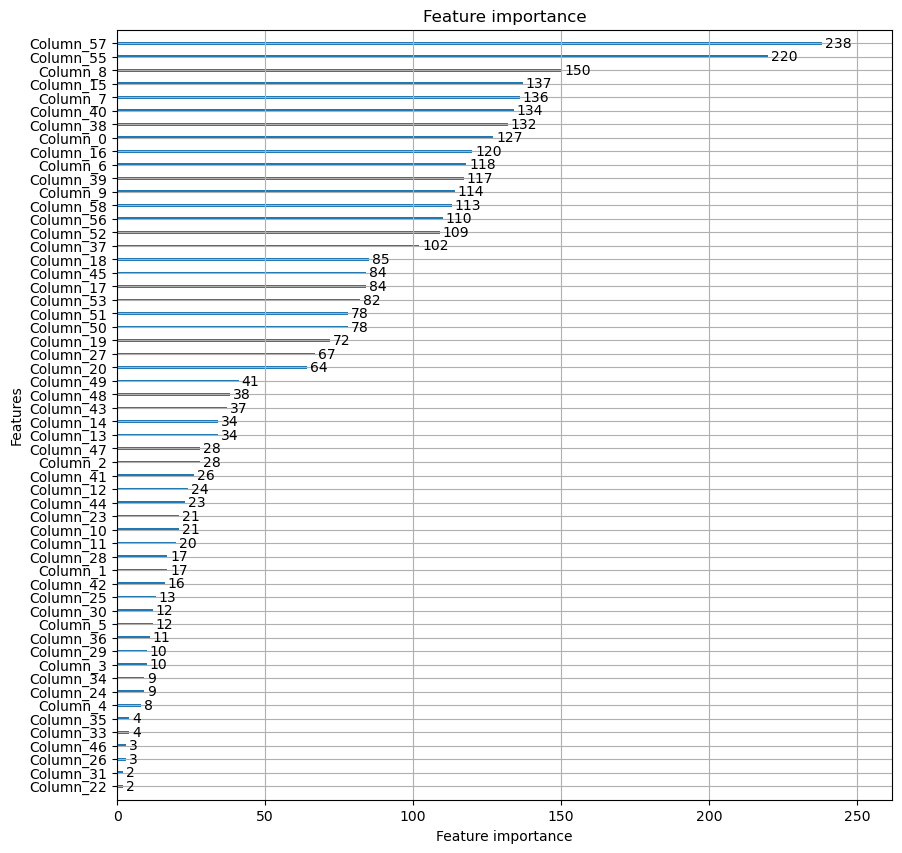

In [13]:
lgbm.plot_importance(lgb,figsize=(10, 10))

In [22]:
lgbm.plot_metric(lgb)

ValueError: eval results cannot be empty.

#### 4. 予測結果の作成
最後にテストデータに対して予測を行い、提出用のcsvファイルを作成します。

In [22]:
# テストデータに対する予測値の作成
# pred = lgb.predict_proba(X_test, num_iteration=lgb.best_iteration)[:, 1]
pred = lgb.predict_proba(X_test)[:, 1]

In [23]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.026152
1,171203,0.173248
2,171204,0.117539
3,171205,0.116774
4,171206,0.182771
...,...,...
61495,232697,0.192995
61496,232698,0.031164
61497,232699,0.052921
61498,232700,0.233861


In [24]:
# 提出用のcsvファイルを作成
sample_sub.to_csv(f'{output_path}/{time}.csv',index=False)